In [1]:
#import libraries

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
particle = pd.read_csv("./all_train.csv")  #Note this is for speed, the goal of the homework is ALL of the data

In [5]:
particle.head(5)

,# label,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f18,f19,f20,f21,f22,f23,f24,f25,f26,mass
0,1.0,-0.346368,0.416306,0.999236,0.475342,0.427493,-0.005984,1.989833,0.344530,1.566297,...,4.105282,0.267826,0.378718,1.743123,3.406367,4.350537,-0.352571,1.130032,2.227706,1000.0
1,1.0,1.708236,-0.319394,-1.241873,-0.887231,-0.871906,-0.005984,-0.001047,-1.038225,0.655748,...,-1.178141,-0.877361,-1.483769,-0.573682,-1.693781,-0.545062,-0.299118,-0.662942,-0.193019,750.0
2,0.0,-0.360693,1.794174,0.264738,-0.472273,-0.292344,-1.054221,-1.150495,1.423404,1.270098,...,-1.199511,0.539020,-1.590629,-0.573682,-0.543636,-0.937456,-0.300344,-0.523262,-1.506304,750.0
3,1.0,-0.377914,-0.103932,-0.649434,-2.125015,-1.643797,-0.005984,1.011112,-1.040340,-0.541991,...,0.463763,-0.006583,1.089122,-0.573682,-0.276348,-0.409272,-0.349926,-0.307123,0.529698,1250.0
4,0.0,-0.067436,-0.636762,-0.620166,-0.062551,1.588715,-0.005984,-0.595304,-1.238987,0.336844,...,-0.552837,-1.418494,-0.562982,1.743123,0.881802,0.002516,1.560950,-0.150760,-1.023889,750.0


In [17]:
particle.shape

(7000000, 29)

In [18]:
#get data and labels
X = particle.iloc[:,1:]
y = particle.iloc[:,0]

#split data into train, test, val set
from sklearn.model_selection import train_test_split
# Get your own cool random seed.
x_temp, x_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, random_state=7979)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.25, random_state=7979)

In [28]:
print(f"Training set size: {len(x_train)} samples")
print(f"Validation set size: {len(x_val)} samples") 
print(f"Test set size: {len(x_test)} samples")

Training set size: 4200000 samples
Validation set size: 1400000 samples
Test set size: 1400000 samples


In [33]:
#scale and standardize data
# Scale and standardize the data
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform training data
X_train_scaled = scaler.fit_transform(x_train)

# Transform validation and test data using the same scaler
X_val_scaled = scaler.transform(x_val)
X_test_scaled = scaler.transform(x_test)

#convert targets from panda to numpy arrays
y_train = y_train.to_numpy()  # or y_train.values
y_val = y_val.to_numpy()      # or y_val.values
y_test = y_test.to_numpy()    # or y_test.values

In [23]:
class ParticleDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class ParticleClassifier(nn.Module):
    def __init__(self, input_features):
        super(ParticleClassifier, self).__init__()
        # Design decisions:
        # 1. Using multiple dense layers with decreasing units to learn hierarchical features
        # 2. Adding dropout for regularization to prevent overfitting
        # 3. Using ReLU activation for hidden layers to help with vanishing gradient
        # 4. Using sigmoid activation for output layer since this is binary classification
        
        self.network = nn.Sequential(
            nn.Linear(input_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.network(x)

In [24]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=100, patience=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total_train += labels.size(0)
            correct_train += (predicted.squeeze() == labels).sum().item()
        
        # Validation phase
        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels.unsqueeze(1))
                
                val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                total_val += labels.size(0)
                correct_val += (predicted.squeeze() == labels).sum().item()
        
        # Calculate metrics
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_accuracy = correct_train / total_val
        val_accuracy = correct_val / total_val
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            model.load_state_dict(best_model_state)
            break
            
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, '
              f'Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}')
    
    return train_losses, val_losses, train_accuracies, val_accuracies

In [34]:
#update datasets with scaled data
train_dataset = ParticleDataset(X_train_scaled, y_train)
val_dataset = ParticleDataset(X_val_scaled, y_val)
test_dataset = ParticleDataset(X_test_scaled, y_test)

In [35]:
#create data loaders with scaled data
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512)
test_loader = DataLoader(test_dataset, batch_size=512)

In [38]:
#setup training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ParticleClassifier(input_features = 28).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

In [39]:
#train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, device
)

Epoch [1/100], Train Loss: 0.2964, Val Loss: 0.2758, Train Acc: 2.5904, Val Acc: 0.8750
Epoch [2/100], Train Loss: 0.2795, Val Loss: 0.2698, Train Acc: 2.6192, Val Acc: 0.8783
Epoch [3/100], Train Loss: 0.2759, Val Loss: 0.2676, Train Acc: 2.6265, Val Acc: 0.8796
Epoch [4/100], Train Loss: 0.2739, Val Loss: 0.2665, Train Acc: 2.6292, Val Acc: 0.8802
Epoch [5/100], Train Loss: 0.2729, Val Loss: 0.2658, Train Acc: 2.6310, Val Acc: 0.8806
Epoch [6/100], Train Loss: 0.2721, Val Loss: 0.2650, Train Acc: 2.6323, Val Acc: 0.8811
Epoch [7/100], Train Loss: 0.2714, Val Loss: 0.2643, Train Acc: 2.6336, Val Acc: 0.8814
Epoch [8/100], Train Loss: 0.2709, Val Loss: 0.2645, Train Acc: 2.6347, Val Acc: 0.8810
Epoch [9/100], Train Loss: 0.2704, Val Loss: 0.2642, Train Acc: 2.6353, Val Acc: 0.8812
Epoch [10/100], Train Loss: 0.2701, Val Loss: 0.2640, Train Acc: 2.6356, Val Acc: 0.8817
Epoch [11/100], Train Loss: 0.2699, Val Loss: 0.2633, Train Acc: 2.6363, Val Acc: 0.8819
Epoch [12/100], Train Loss: 0.

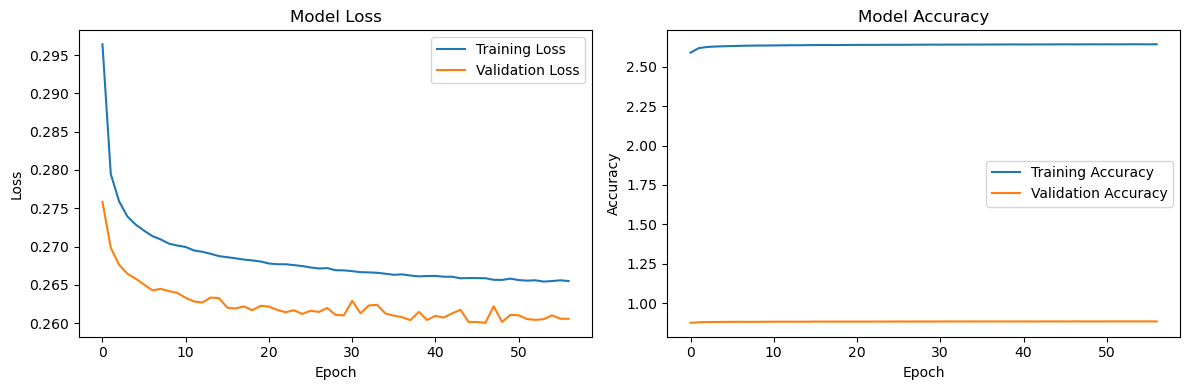

In [40]:
#plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [44]:
#evaluate final model performance
model.eval()
with torch.no_grad():
    test_dataset = ParticleDataset(X_test_scaled, y_test)
    test_loader = DataLoader(test_dataset, batch_size=512)
    correct = 0
    total = 0
    
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted.squeeze() == labels).sum().item()

test_accuracy = correct / total
print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")


Final Test Accuracy: 0.8839
